In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import importlib

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D

from itertools import chain
from random import shuffle, sample

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric

sys.path.append('..')
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initial Exploration

In [45]:
bad1 = torch.load('/global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps_SMALLTEST/1423')
bad2 = torch.load('/global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps_SMALLTEST/1346')
good1 = torch.load('/global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps_SMALLTEST/1230')
good2 = torch.load('/global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps_SMALLTEST/1375')

## Good result

### 1

In [104]:
good = filter_hit_pt([good1], 1.0)[0]

In [105]:
good_pt = fetch_pt(good)

In [106]:
good_pt

array([1.2910028, 1.1413449, 1.3635843, ..., 1.35948  , 1.0586314,
       1.0892017], dtype=float32)

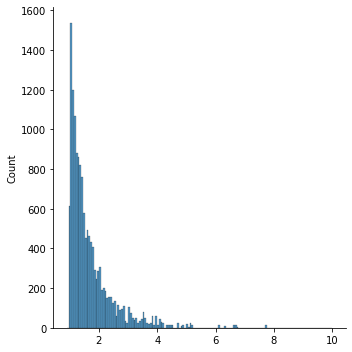

In [107]:
sns.displot(good_pt, binrange=(0.9, 10))

In [108]:
good_e = good.layerless_true_edges

In [109]:
good_pt_av = (good_pt[good_e[0]] + good_pt[good_e[1]])/2

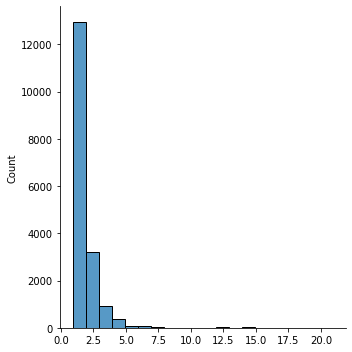

In [110]:
sns.displot(good_pt_av, binrange=(0.9, 20), binwidth= 1)

### 2

In [111]:
good = filter_hit_pt([good2], 1.0)[0]

In [112]:
good_pt = fetch_pt(good)

In [113]:
good_pt

array([1.9339756, 1.0793401, 1.5815953, ..., 1.0380954, 3.9936383,
       1.1697642], dtype=float32)

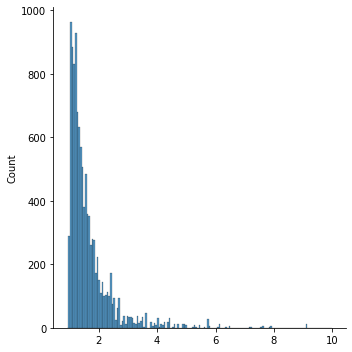

In [114]:
sns.displot(good_pt, binrange=(0.9, 10))

In [115]:
good_e = good.layerless_true_edges

In [116]:
good_pt_av = (good_pt[good_e[0]] + good_pt[good_e[1]])/2

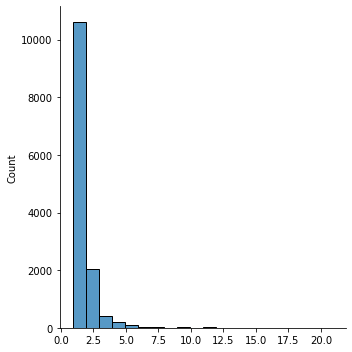

In [117]:
sns.displot(good_pt_av, binrange=(0.9, 20), binwidth= 1)

## Bad result

### 1

In [118]:
bad = filter_hit_pt([bad1], 1.0)[0]

In [119]:
bad_pt = fetch_pt(bad)

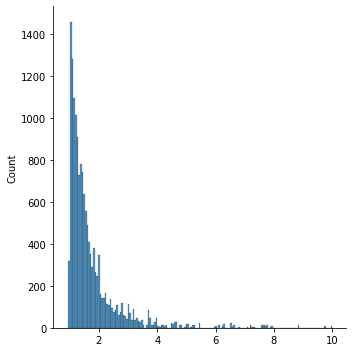

In [120]:
sns.displot(bad_pt, binrange=(0.9, 10))

In [121]:
bad_e = bad.layerless_true_edges

In [122]:
bad_pt_av = (bad_pt[bad_e[0]] + bad_pt[bad_e[1]])/2

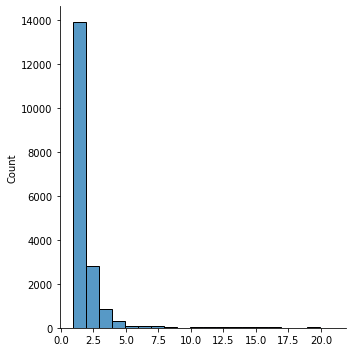

In [123]:
sns.displot(bad_pt_av, binrange=(0.9, 20), binwidth= 1)

### 2

In [124]:
bad = filter_hit_pt([bad2], 1.0)[0]

In [125]:
bad_pt = fetch_pt(bad)

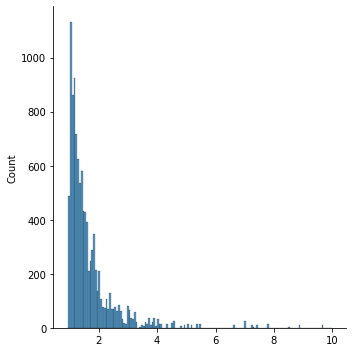

In [126]:
sns.displot(bad_pt, binrange=(0.9, 10))

In [127]:
bad_e = bad.layerless_true_edges

In [128]:
bad_pt_av = (bad_pt[bad_e[0]] + bad_pt[bad_e[1]])/2

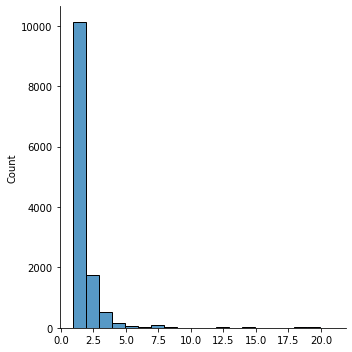

In [129]:
sns.displot(bad_pt_av, binrange=(0.9, 20), binwidth= 1)

# Deeper Dive

## Load Model

In [18]:
from utils.stage_utils import get_resume_id, load_config, combo_config, dict_to_args, get_logger, build_model, build_trainer, autocast
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import filter_hit_pt, fetch_pt, fetch_type, load_dataset, graph_intersection, build_edges, res

In [80]:
stage = {"set": "Embedding", "name": "LayerlessEmbedding", "config": "train_coda_small_embedding.yaml", "resume_id": "suvpgvg8"}
libraries = {
    "model_library": "/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/Examples/LightningModules",
    "artifact_library": "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints"
}

In [81]:
resume_id = get_resume_id(stage)

In [82]:
model_config = load_config(stage, resume_id, libraries)

In [83]:
model_dir = os.path.join(libraries["artifact_library"], model_config["project"], resume_id)
model_name = "last.ckpt-v1.ckpt"

### Simple Load

In [84]:
model = LayerlessEmbedding.load_from_checkpoint(os.path.join(model_dir, model_name)).to(device)

### Manual Load

In [7]:
chkpnt = torch.load(os.path.join(model_dir, model_name))

In [32]:
chkpnt["hparams_name"] = "hyper_parameters"

In [9]:
chkpnt["hparams_name"]

'kwargs'

In [10]:
chkpnt

{'epoch': 26,
 'global_step': 10400,
 'pytorch-lightning_version': '1.0.5',
 'callbacks': {pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint: {'best_model_score': tensor(0.8084, device='cuda:0'),
   'best_model_path': '/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints/CodaEmbeddingStudy/i6iagwzk/last.ckpt-v1.ckpt'}},
 'optimizer_states': [{'state': {0: {'step': 10400,
     'exp_avg': tensor([[ 6.3095e-04, -3.5554e-05,  2.1710e-04,  ..., -1.7610e-05,
              -2.5872e-05, -3.4252e-06],
             [ 4.9525e-03,  1.4033e-03,  5.9436e-05,  ...,  7.5639e-05,
              -7.5676e-05,  1.4260e-04],
             [-3.0100e-04,  5.8684e-05,  3.9522e-04,  ..., -2.6474e-05,
              -1.9765e-04,  2.1989e-04],
             ...,
             [-6.9187e-04, -2.3776e-04, -1.2555e-04,  ..., -1.7638e-05,
               1.0570e-04, -5.0850e-05],
             [-1.5313e-03, -3.8356e-04, -1.0561e-04,  ..., -1.9670e-05,
               5.0182e-05,  7.9132e-05],
             [

In [43]:
model = LayerlessEmbedding(chkpnt["hyper_parameters"])
model.load_state_dict(chkpnt["state_dict"])

<All keys matched successfully>

In [54]:
model = model.to(device)

## Apply to Test Set

In [11]:
model.setup("fit")

In [12]:
test_set = model.test_dataloader()

In [85]:
test_set = model.testset

ModuleAttributeError: 'LayerlessEmbedding' object has no attribute 'testset'

In [92]:
%%time
easy_events = []
hard_events = []
tp_list = []
t_list = []
p_list = []
size_list = []

with torch.no_grad():
    for i, data in enumerate(test_set.dataset[:100]):
        batch = data.to(device)

        if 'ci' in model.hparams["regime"]:
            spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = model(batch.x)

        e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1)

        # Build whole KNN graph
        e_spatial = build_edges(spatial, 1.5, 200, res)

        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
        
        data.true_positives = e_spatial[:, y_cluster]
        
        cluster_true = e_bidir.shape[1]
        cluster_true_positive = y_cluster.sum().item()
        cluster_positive = len(e_spatial[0])
        
        tp_list.append(cluster_true_positive)
        p_list.append(cluster_positive)
        t_list.append(cluster_true)
        size_list.append(len(batch.hid))
        
        eff = torch.tensor(cluster_true_positive / cluster_true)
        pur = torch.tensor(cluster_true_positive / cluster_positive)
        
        if(eff < 0.95):
            print("HARD:", eff, pur, len(batch.hid))
            hard_events.append(i)
        else:
            print("EASY:", eff, pur, len(batch.hid))
            easy_events.append(i)

HARD: tensor(0.9005) tensor(0.0637) 107725
HARD: tensor(0.9009) tensor(0.0672) 103256
HARD: tensor(0.9020) tensor(0.0694) 98733
HARD: tensor(0.8937) tensor(0.0804) 82080
HARD: tensor(0.8933) tensor(0.0703) 92650
HARD: tensor(0.8883) tensor(0.0799) 82769
HARD: tensor(0.8948) tensor(0.0697) 94976
HARD: tensor(0.8907) tensor(0.0642) 104643
HARD: tensor(0.8942) tensor(0.0664) 100745
HARD: tensor(0.8951) tensor(0.0698) 100305
HARD: tensor(0.9005) tensor(0.0705) 95318
HARD: tensor(0.8990) tensor(0.0711) 97181
HARD: tensor(0.8933) tensor(0.0711) 95585
HARD: tensor(0.8982) tensor(0.0631) 108737
HARD: tensor(0.8997) tensor(0.0832) 79983
HARD: tensor(0.8929) tensor(0.0955) 62791
HARD: tensor(0.8962) tensor(0.0699) 99610
HARD: tensor(0.8951) tensor(0.0634) 109360
HARD: tensor(0.8890) tensor(0.0788) 84199
HARD: tensor(0.9019) tensor(0.0929) 70136
HARD: tensor(0.8998) tensor(0.0820) 81168
HARD: tensor(0.8931) tensor(0.0705) 96502
HARD: tensor(0.8890) tensor(0.0772) 86852
HARD: tensor(0.8946) tensor

In [93]:
eff_list, pur_list = np.array(tp_list) / np.array(t_list), np.array(tp_list) / np.array(p_list)
size_list = np.array(size_list)

In [28]:
len(easy_events), len(hard_events)

(437, 63)

## Eff, Pur Analysis

In [94]:
print(stats(eff_list))
print(stats(pur_list))

{'mean': 0.8946963514879711, 'st.dev': 0.004045087877398759}
{'mean': 0.07350358721857095, 'st.dev': 0.008287965230315088}


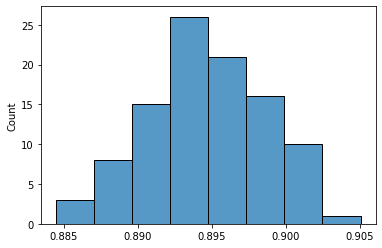

In [95]:
sns.histplot(eff_list)

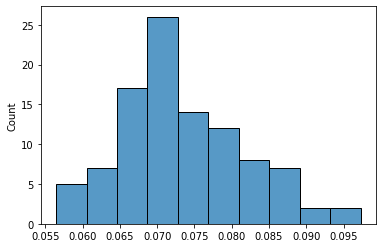

In [96]:
sns.histplot(pur_list)

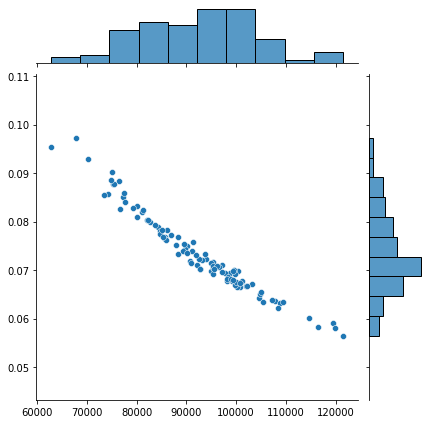

In [100]:
sns.jointplot(x = size_list, y=pur_list)

## pT Analysis

### Examine Easy Events

In [61]:
def stats(lst):
    return {"mean": np.mean(lst), "st.dev": np.std(lst)}

In [114]:
easy_pt = []
easy_pt_av = []
easy_mean_pt = []

In [117]:
for i in easy_events:
    easy = test_set.dataset[i].to("cpu")
    pt = easy.pt.numpy()
    if (pt > 1000).any():
        print(easy)
    else:
        easy_pt.append(pt)
        easy_e = easy.layerless_true_edges
        easy_pt_av.append((pt[easy_e[0]] + pt[easy_e[1]])/2)
        easy_mean_pt.append(np.mean(pt))
easy_pt = np.concatenate(easy_pt)
easy_pt_av = np.concatenate(easy_pt_av)

Data(cell_data=[14101, 9], event_file="/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021313", hid=[14101], layerless_true_edges=[2, 17043], layers=[14101], pid=[14101], pt=[14101], true_positives=[2, 33856], weights=[17043], x=[14101, 3])


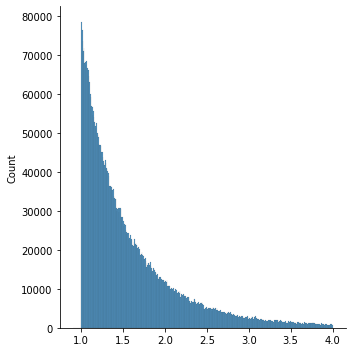

In [118]:
sns.displot(easy_pt, binrange=(0.9, 4))

In [119]:
print("HITS:", stats(easy_pt))
print("EDGES:", stats(easy_pt_av))

HITS: {'mean': 1.7880038, 'st.dev': 2.2337546}
EDGES: {'mean': 1.7752995, 'st.dev': 2.2075207}


### Examine Hard Events

In [122]:
hard_pt = []
hard_pt_av = []
hard_mean_pt = []

In [124]:
for i in hard_events:
    hard = test_set.dataset[i].to("cpu")
    pt = hard.pt.numpy()
    if (pt > 1000).any():
        print(hard)
    else:
        hard_pt.append(pt)
        hard_e = hard.layerless_true_edges
        hard_pt_av.append((pt[hard_e[0]] + pt[hard_e[1]])/2)
        hard_mean_pt.append(np.mean(pt))
hard_pt = np.concatenate(hard_pt)
hard_pt_av = np.concatenate(hard_pt_av)

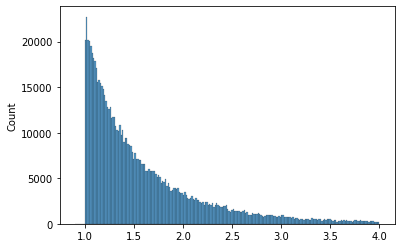

In [125]:
sns.histplot(hard_pt, binrange=(0.9, 4))

In [126]:
print("HITS:", stats(hard_pt))
print("EDGES:", stats(hard_pt_av))

HITS: {'mean': 1.7901201, 'st.dev': 2.0250943}
EDGES: {'mean': 1.7783368, 'st.dev': 1.9478983}


### Compare Stats

#### Across pT

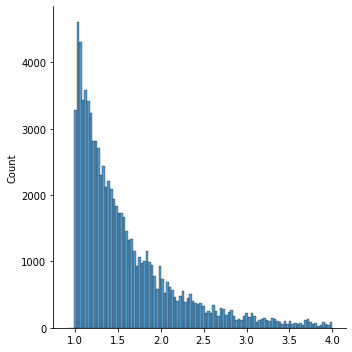

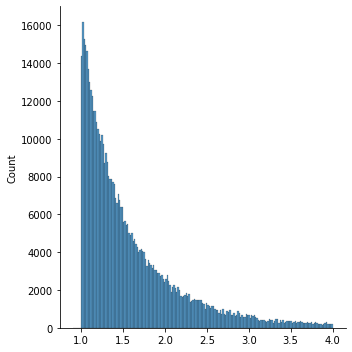

In [150]:
sns.displot(hard_pt, binrange=(0.9, 4))
sns.displot(easy_pt, binrange=(0.9, 4))

In [196]:
print("HITS:", stats(hard_pt))
print("EDGES:", stats(hard_pt_av))

HITS: {'mean': 1.7814902, 'st.dev': 2.0895734}
EDGES: {'mean': 1.7685859, 'st.dev': 1.9981616}


In [197]:
print("HITS:", stats(easy_pt))
print("EDGES:", stats(easy_pt_av))

HITS: {'mean': 1.9182626, 'st.dev': 2.496019}
EDGES: {'mean': 1.7816447, 'st.dev': 2.1720493}


#### Across Events

In [127]:
print("HITS:", stats(hard_mean_pt))

HITS: {'mean': 1.7924782, 'st.dev': 0.095649555}


In [128]:
print("HITS:", stats(easy_mean_pt))

HITS: {'mean': 1.7907491, 'st.dev': 0.10838934}


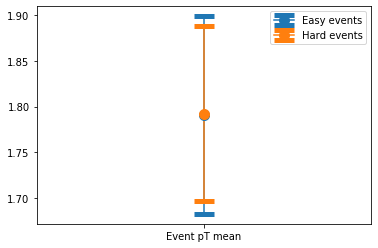

In [129]:
x = np.array(["Event pT mean"])
y = np.array([stats(easy_mean_pt)["mean"]])
e = np.array([stats(easy_mean_pt)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Easy events")
x = np.array(["Event pT mean"])
y = np.array([stats(hard_mean_pt)["mean"]])
e = np.array([stats(hard_mean_pt)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Hard events")
plt.legend()

## Eta Analysis

### Examine Easy Events

In [10]:
def stats(lst):
    return {"mean": np.mean(lst), "st.dev": np.std(lst)}

In [9]:
def calc_eta(X):
    theta = np.arctan2(X[:,0], X[:,2])
    return -1. * np.log(np.tan(theta / 2.))

In [132]:
easy_eta = []
easy_eta_av = []
easy_mean_eta = []

In [133]:
for i in easy_events:
    easy = test_set.dataset[i].to("cpu")
    eta = calc_eta(easy.x)
    easy_eta.append(eta)
    easy_e = easy.layerless_true_edges
    easy_eta_av.append((eta[easy_e[0]] + eta[easy_e[1]])/2)
    easy_mean_eta.append(np.mean(eta.numpy()))
easy_eta = np.concatenate(easy_eta)
easy_eta_av = np.concatenate(easy_eta_av)

In [134]:
print("HITS:", stats(easy_eta))
print("EDGES:", stats(easy_eta_av))

HITS: {'mean': -0.0031981939, 'st.dev': 2.180783}
EDGES: {'mean': -0.0063784765, 'st.dev': 2.36429}


### Examine Hard Events

In [135]:
hard_eta = []
hard_eta_av = []
hard_mean_eta = []

In [136]:
for i in hard_events:
    hard = test_set.dataset[i].to("cpu")
    eta = calc_eta(hard.x)
    hard_eta.append(eta)
    hard_e = hard.layerless_true_edges
    hard_eta_av.append((eta[hard_e[0]] + eta[hard_e[1]])/2)
    hard_mean_eta.append(np.mean(eta.numpy()))
hard_eta = np.concatenate(hard_eta)
hard_eta_av = np.concatenate(hard_eta_av)

In [137]:
print("HITS:", stats(hard_eta))
print("EDGES:", stats(hard_eta_av))

HITS: {'mean': -0.0033109067, 'st.dev': 2.1824088}
EDGES: {'mean': -0.0059369192, 'st.dev': 2.3659937}


### Compare Stats

#### Across eta

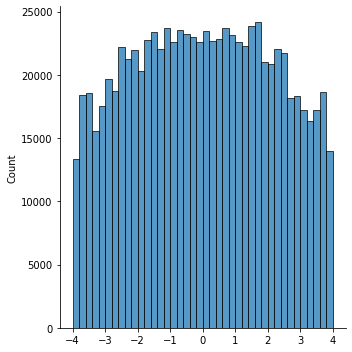

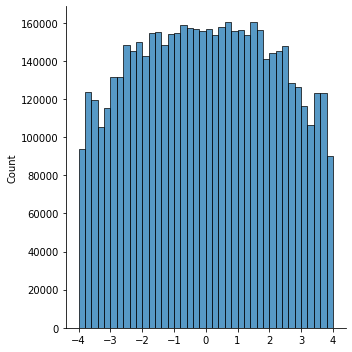

In [138]:
sns.displot(hard_eta, binrange=(-4, 4), binwidth=0.2)
sns.displot(easy_eta, binrange=(-4, 4), binwidth=0.2)

In [139]:
print("HITS:", stats(hard_eta))
print("EDGES:", stats(hard_eta_av))

HITS: {'mean': -0.0033109067, 'st.dev': 2.1824088}
EDGES: {'mean': -0.0059369192, 'st.dev': 2.3659937}


In [140]:
print("HITS:", stats(easy_eta))
print("EDGES:", stats(easy_eta_av))

HITS: {'mean': -0.0031981939, 'st.dev': 2.180783}
EDGES: {'mean': -0.0063784765, 'st.dev': 2.36429}


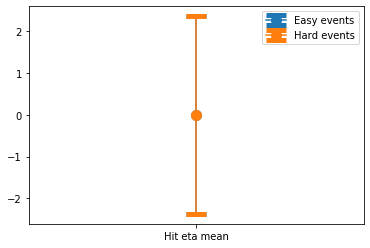

In [141]:
x = np.array(["Hit eta mean"])
y = np.array([stats(easy_eta_av)["mean"]])
e = np.array([stats(easy_eta_av)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Easy events")
x = np.array(["Hit eta mean"])
y = np.array([stats(hard_eta_av)["mean"]])
e = np.array([stats(hard_eta_av)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Hard events")
plt.legend()

#### Across Events

In [142]:
print("HITS:", stats(hard_mean_eta))

HITS: {'mean': -0.0034919418, 'st.dev': 0.10115595}


In [143]:
print("HITS:", stats(easy_mean_eta))

HITS: {'mean': -0.0013115018, 'st.dev': 0.10162141}


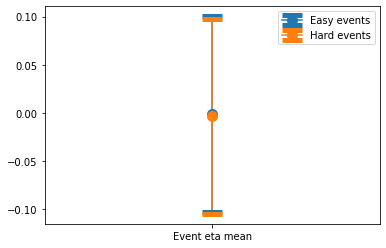

In [144]:
x = np.array(["Event eta mean"])
y = np.array([stats(easy_mean_eta)["mean"]])
e = np.array([stats(easy_mean_eta)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Easy events")
x = np.array(["Event eta mean"])
y = np.array([stats(hard_mean_eta)["mean"]])
e = np.array([stats(hard_mean_eta)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Hard events")
plt.legend()

## pT vs Efficiency Analysis

### Easy Events

In [145]:
easy_pt_tp = []
easy_pt_t = []

In [146]:
%%time
for i in easy_events[:100]:
    easy = test_set.dataset[i].to("cpu")
    pt = easy.pt.numpy()
    if (pt>1000).any():
        print(easy)
    else:
        true_positives = easy.true_positives
        true = torch.cat([easy.layerless_true_edges, easy.layerless_true_edges.flip(0)], axis=-1)
        easy_pt_tp.append(pt[true_positives])
        easy_pt_t.append(pt[true])
    # CAN SLICE ALONG ALL PTs OR EVENT-BY-EVENT
#     easy_pt.append(pt)
#     easy_e = easy.layerless_true_edges
#     easy_pt_av.append((pt[easy_e[0]] + pt[easy_e[1]])/2)
#     easy_mean_pt.append(np.mean(pt))
easy_pt_tp = np.concatenate(easy_pt_tp, axis=1)
easy_pt_t = np.concatenate(easy_pt_t, axis=1)

CPU times: user 219 ms, sys: 27.8 ms, total: 247 ms
Wall time: 132 ms


In [147]:
easy_pt_tp_av = (easy_pt_tp[0] + easy_pt_tp[1])/2
easy_pt_t_av = (easy_pt_t[0] + easy_pt_t[1])/2

In [148]:
bins = np.logspace(0, 1.5, 10)
centers = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

tp_hist = np.histogram(easy_pt_tp_av, bins=bins)[0]
t_hist = np.histogram(easy_pt_t_av, bins=bins)[0]
easy_ratio_hist = tp_hist / t_hist

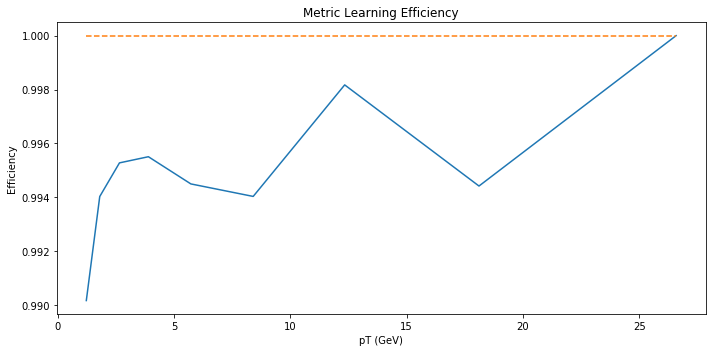

In [149]:
# Update this to dynamically adapt to number of metrics
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
axs = axs.flatten() if type(axs) is list else [axs]

axs[0].plot(centers, easy_ratio_hist)
axs[0].plot([centers[0], centers[-1]], [1, 1], '--')
axs[0].set_xlabel('pT (GeV)')
axs[0].set_ylabel('Efficiency')
axs[0].set_title('Metric Learning Efficiency')
plt.tight_layout()

### Hard Events

In [150]:
hard_pt_tp = []
hard_pt_t = []

In [151]:
%%time
for i in hard_events:
    hard = test_set.dataset[i].to("cpu")
    pt = hard.pt.numpy()
    if (pt > 1000).any():
        print(hard)
    else:
        true_positives = hard.true_positives
        true = torch.cat([hard.layerless_true_edges, hard.layerless_true_edges.flip(0)], axis=-1)
        hard_pt_tp.append(pt[true_positives])
        hard_pt_t.append(pt[true])
    # CAN SLICE ALONG ALL PTs OR EVENT-BY-EVENT
#     easy_pt.append(pt)
#     easy_e = easy.layerless_true_edges
#     easy_pt_av.append((pt[easy_e[0]] + pt[easy_e[1]])/2)
#     easy_mean_pt.append(np.mean(pt))
hard_pt_tp = np.concatenate(hard_pt_tp, axis=1)
hard_pt_t = np.concatenate(hard_pt_t, axis=1)

CPU times: user 162 ms, sys: 16.2 ms, total: 178 ms
Wall time: 102 ms


In [152]:
hard_pt_tp_av = (hard_pt_tp[0] + hard_pt_tp[1])/2
hard_pt_t_av = (hard_pt_t[0] + hard_pt_t[1])/2

In [153]:
bins = np.logspace(0, 1.5, 10)
centers = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

tp_hist = np.histogram(hard_pt_tp_av, bins=bins)[0]
t_hist = np.histogram(hard_pt_t_av, bins=bins)[0]
hard_ratio_hist = tp_hist / t_hist

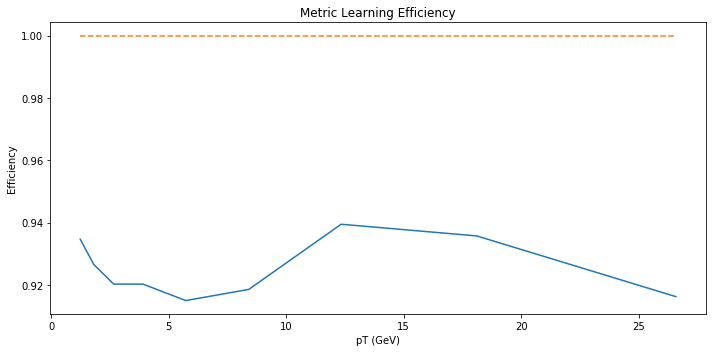

In [154]:
# Update this to dynamically adapt to number of metrics
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
axs = axs.flatten() if type(axs) is list else [axs]

axs[0].plot(centers, hard_ratio_hist)
axs[0].plot([centers[0], centers[-1]], [1, 1], '--')
axs[0].set_xlabel('pT (GeV)')
axs[0].set_ylabel('Efficiency')
axs[0].set_title('Metric Learning Efficiency')
plt.tight_layout()

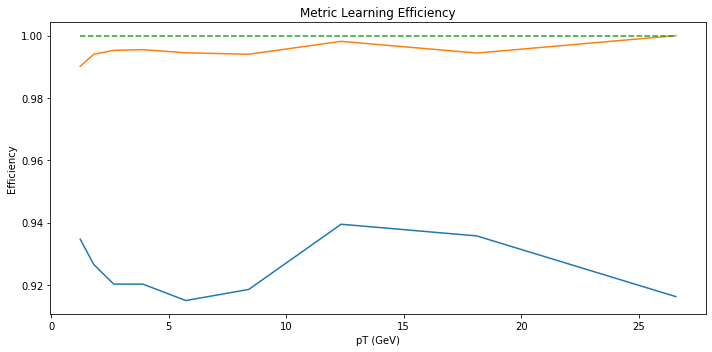

In [155]:
# Update this to dynamically adapt to number of metrics
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
axs = axs.flatten() if type(axs) is list else [axs]

axs[0].plot(centers, hard_ratio_hist)
axs[0].plot(centers, easy_ratio_hist)
axs[0].plot([centers[0], centers[-1]], [1, 1], '--')
axs[0].set_xlabel('pT (GeV)')
axs[0].set_ylabel('Efficiency')
axs[0].set_title('Metric Learning Efficiency')
plt.tight_layout()

## Jet Analysis

### Example...

In [134]:
from pyjet import cluster
from pyjet.testdata import get_event

vectors = get_event()
sequence = cluster(vectors, R=1.0, p=-1)
jets = sequence.inclusive_jets()  # list of PseudoJets
exclusivejets = sequence.exclusive_jets(3)  # Find the cluster history when there are 3 jets

In [135]:
jets[0]

PseudoJet(pt=983.387, eta=-0.868, phi=2.905, mass=39.991)

[(1.51535651e+00, -5.33650888, -2.19101187,  4.93600006e-01)
 (2.38211217e-01, -4.40409474,  1.59250675,  1.39570002e-01)
 (2.71899543e-01, -3.93089818,  1.43715817,  1.39569999e-01)
 (2.63393743e-01, -1.68243005, -2.56397904,  1.39570000e-01)
 (1.64420492e+00, -2.0335164 ,  0.68656051,  1.39570000e-01)
 (6.75280764e-01, -5.15556952, -2.57445178,  9.39570002e-01)
 (5.46421684e-01, -5.20350406, -1.02424553,  9.38269999e-01)
 (1.54134496e+00, -4.39936469,  1.13471278,  9.39570000e-01)
 (1.46827903e-01, -4.54880067, -0.21474025,  1.39570000e-01)
 (2.21829393e+00, -2.60237495,  1.34660981,  1.39569997e-01)
 (2.52247572e-01, -2.73435675, -0.31697376,  1.39570000e-01)
 (3.39499059e-01, -1.63170226,  0.15270001,  1.39570000e-01)
 (1.10764361e+00, -1.13065468, -2.3589616 ,  1.39570000e-01)
 (2.06824854e-01, -1.91178238, -1.01292686,  1.39570000e-01)
 (1.71301882e+00, -2.03656511, -2.46861524,  9.39570000e-01)
 (4.61349221e-01, -1.35600282, -3.1051276 ,  1.39570000e-01)
 (2.19975694e+00, -1.746

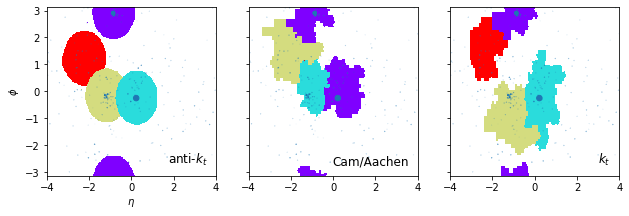

In [136]:
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -4., 4.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 200

event = get_event()
print(event)
# create regular grid of ghosts
eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
X, Y = np.meshgrid(eta, phi)
ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
ghosts['pT'] = 1e-8
ghosts['eta'] = X.ravel()
ghosts['phi'] = Y.ravel()

# add ghosts to the event
event = np.concatenate([event, ghosts], axis=0)

fig = plt.figure(figsize=(9, 3))

ax = None
for p, label in zip((-1, 0, 1), (r'anti-$k_t$', 'Cam/Aachen', '$k_t$')):
    # cluster
    sequence = cluster(event, R=1.0, p=p)
    jets = sequence.inclusive_jets(ptmin=10)

    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = fig.add_subplot(1, 3, p + 2, sharey=ax)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                    dtype=np.float64)
    for ijet, jet in enumerate(jets):
        constit = jet.constituents_array()
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    particles = get_event()
    ax.scatter(particles['eta'], particles['phi'],
               s=30 * particles['pT'] / particles['pT'].max())
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    if p == -1:
        ax.set_ylabel(r'$\phi$')
        ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.05, label,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
fig.tight_layout()

### Single Event Exploration

In [128]:
loaded_event = torch.load('/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/feature_store_endcaps_SMALLTEST/21547', map_location="cpu")

In [137]:
eta = calc_eta(loaded_event.x)
phi = loaded_event.x[:, 1]
pts = fetch_pt(loaded_event)
types = fetch_type(loaded_event)

In [133]:
(pts < 1).sum()

73769

Create dictionary of masses, given

| Code | Particle | Mass (GeV) |
| -- | -- | --- |
| 11 | Electron | 5.10999e-4 |
| 13 | Muon | 1.05658e-1 |
| 211 | Pion | 1.3957018e-1 |
| 321 | Kaon | 4.93677e-1 |
| 2212 | Proton | 9.3827e-1 |

In [138]:
mass_dict = {11: 5.10999e-4, 
             -11: 5.10999e-4, 
             13: 1.05658e-1, 
             -13: 1.05658e-1, 
             211: 1.3957018e-1, 
             -211: 1.3957018e-1, 
             321: 4.93677e-1, 
             -321: 4.93677e-1, 
             2212: 9.3827e-1, 
             -2212: 9.3827e-1}

In [139]:
masses = np.array([mass_dict[type_i] for type_i in types])

In [110]:
vectors = np.vstack([pts, eta, phi, masses])

In [111]:
dtype = [('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]

In [92]:
vectors = np.array(list(zip(*vectors)), dtype=dtype)

In [64]:
sequence = cluster(vectors, R=1.0, p=-1)
jets = sequence.inclusive_jets()  # list of PseudoJets
exclusivejets = sequence.exclusive_jets(3)  # Find the cluster history when there are 3 jets

In [140]:
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -4., 4.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 200

vectors = np.vstack([pts, eta, phi, masses])
dtype = [('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]
event = np.array(list(zip(*vectors)), dtype=dtype)

In [141]:
# create regular grid of ghosts
eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
X, Y = np.meshgrid(eta, phi)
ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
ghosts['pT'] = 1e-8
ghosts['eta'] = X.ravel()
ghosts['phi'] = Y.ravel()

In [142]:
event

array([(0.10988694,  1.98613894,  0.26886129, 0.93827   ),
       (0.22541498,  3.23709583, -0.94964838, 0.13957018),
       (0.22465253, -0.56972402, -0.08642769, 0.13957018), ...,
       (0.24869327,  2.17174935,  0.24982309, 0.93827   ),
       (0.24769624,  2.17809844,  0.24891607, 0.93827   ),
       (0.29983246,  1.32959068, -0.52913904, 0.13957018)],
      dtype=[('pT', '<f8'), ('eta', '<f8'), ('phi', '<f8'), ('mass', '<f8')])

In [143]:
ghosts

array([(1.e-08, -3.98, -3.12588469, 0.), (1.e-08, -3.94, -3.12588469, 0.),
       (1.e-08, -3.9 , -3.12588469, 0.), ...,
       (1.e-08,  3.9 ,  3.12588469, 0.), (1.e-08,  3.94,  3.12588469, 0.),
       (1.e-08,  3.98,  3.12588469, 0.)],
      dtype=[('pT', '<f8'), ('eta', '<f8'), ('phi', '<f8'), ('mass', '<f8')])

In [144]:
# add ghosts to the event
event = np.concatenate([event, ghosts], axis=0)



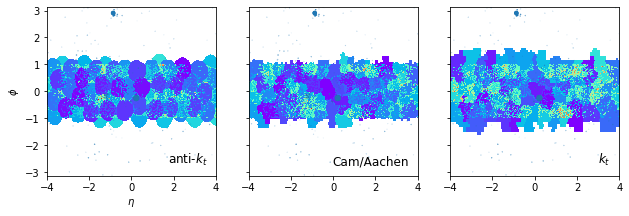

In [145]:
fig = plt.figure(figsize=(9, 3))

ax = None
for p, label in zip((-1, 0, 1), (r'anti-$k_t$', 'Cam/Aachen', '$k_t$')):
    # cluster
    sequence = cluster(event, R=0.4, p=p)
    jets = sequence.inclusive_jets(ptmin=10)

    # pick a different color for each jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets)))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = fig.add_subplot(1, 3, p + 2, sharey=ax)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                    dtype=np.float64)
    for ijet, jet in enumerate(jets):
        constit = jet.constituents_array()
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    particles = get_event()
    ax.scatter(particles['eta'], particles['phi'],
               s=30 * particles['pT'] / particles['pT'].max())
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    if p == -1:
        ax.set_ylabel(r'$\phi$')
        ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.05, label,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
fig.tight_layout()